# NV Center Qubit

To run this tutorial please make sure you have installed and enabled ipywidgets:
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```
## Setup
### Imports

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

from qblox_instruments import Cluster, ClusterType
from qcodes import Instrument
from qcodes.instrument.parameter import ManualParameter

from quantify_core.data import handling as dh
from quantify_core.measurement.control import MeasurementControl
import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

from quantify_scheduler.backends import SerialCompiler
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.gettables import ScheduleGettable
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent, QRMComponent
from quantify_scheduler.instrument_coordinator.components.generic import GenericInstrumentCoordinatorComponent
from quantify_scheduler.schedules.schedule import Schedule

### Scan for Clusters
We scan for the available clusters on our network using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).


In [ ]:
import ipywidgets as widgets
from IPython.display import display

from qblox_instruments import PlugAndPlay
import numpy as np

# Scan for available devices and display
with PlugAndPlay() as p:
    # Get info of all devices
    device_list = p.list_devices()

names = {dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()}
ip_addresses = {dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()}

# Create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[["Dummy-Cluster", "dummy_cluster"]]
    + [(f"{names[dev_id]} @{ip_addresses[dev_id]}", dev_id) for dev_id in device_list.keys()],
    description="Select Device",
)
display(connect)

### Connect to Cluster
We now make a connection with the Cluster selected in the dropdown widget. We also define a function to find the modules we're interested in. We select the readout and control module we want to use.

In [ ]:
from qblox_instruments import Cluster, ClusterType
from qcodes import Instrument

# Connect to device
dev_id = connect.value
try:  # Close the chosen QCodes instrument as to prevent name clash
    Instrument.find_instrument(dev_id).close()
except KeyError:
    pass

cluster = Cluster(
    name="Cluster",
    identifier=ip_addresses.get(dev_id),
    dummy_cfg={
        1: ClusterType.CLUSTER_QCM,
        2: ClusterType.CLUSTER_QRM,
        3: ClusterType.CLUSTER_QCM_RF,
        4: ClusterType.CLUSTER_QRM_RF,
    } if dev_id == "dummy_cluster" else None,
)

print(f"{connect.label} connected")

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

**Note**: A dummy cluster will raise temperature error flags, this is normal behavior and can be safely ignored.

In [ ]:
cluster.reset()
print(cluster.get_system_state())

In [ ]:
def select_module_widget(
    cluster: Cluster, select_all: bool = False, select_qrm_type: bool = True, select_rf_type: bool = False
):
    """
    Create a widget to select modules of a certain type. Default is to show only QRM baseband.

    Args:
        cluster (Cluster): Cluster we are currently using
        select_all (bool): ignore filters and show all modules
        select_qrm_type (bool): filter QRM/QCM
        select_rf_type (bool): filter RF/baseband
    """
    options = [[None, None]]

    for module in cluster.modules:
        if module.present():
            if select_all or (
                module.is_qrm_type == select_qrm_type
                and module.is_rf_type == select_rf_type
            ):
                options.append(
                    [
                        f"{module.name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [ ]:
print("Select the Readout module from the available modules:") 
select_qrm = select_module_widget(cluster, select_qrm_type=True, select_rf_type=False)
print("Select the Control module from the available modules:")
select_qcm = select_module_widget(cluster, select_qrm_type=False, select_rf_type=False)
print("Select the RF Control module from the available modules:")
select_qcm_rf = select_module_widget(cluster, select_qrm_type=False, select_rf_type=True)

In [ ]:
readout_module = select_qrm.value
control_module = select_qcm.value
rf_control_module = select_qcm_rf.value

print(f"Readout module in slot {readout_module.slot_idx} connected")
print(f"Control module in slot {control_module.slot_idx} connected")
print(f"RF control module in slot {rf_control_module.slot_idx} connected")

In [ ]:
from quantify_scheduler.helpers.mock_instruments import MockLocalOscillator

lo_readout_laser = MockLocalOscillator("lo_readout_laser")

### Connect to the Cluster in Quantify


In [ ]:
dh.set_datadir(dh.default_datadir())

# Close any QCodes instrument that will be opened
for name in ["meas_ctrl", "plotmon", "Instrument_Monitor", "ic", "ic_generic", "ic_lo_readout_laser", f"ic_{cluster.name}",
            f"ic_{readout_module.name}",f"ic_{control_module.name}",
             f"ic_{rf_control_module.name}"]: 
    try:
        Instrument.find_instrument(name).close()
    except KeyError:
        pass

meas_ctrl = MeasurementControl("meas_ctrl")
# Create the live plotting isntrument which handles the graphical interface
# Two windows will be created, the main will feature 1D plots and any 2D plots will go
# to the secondary

plotmon = pqm.PlotMonitor_pyqt("plotmon")
# Connect the live plotting monitor to the measurement control
meas_ctrl.instr_plotmon(plotmon.name)

# # The instrument monitor will give an overview of all parameters of all instruments
insmon = InstrumentMonitor("Instrument_Monitor")

ic = InstrumentCoordinator("ic")
ic_cluster = ClusterComponent(cluster)
ic.add_component(ic_cluster)
ic.add_component(
    GenericInstrumentCoordinatorComponent(lo_readout_laser)
)

### Quantum Device Configuration

To generate the device configuration on the fly, `quantify_scheduler` provides the `QuantumDevice` and `BasicElectronicNVElement` classes, with the latter being specifically for NV-Center experiments. `QuantumDevice` can contain multiple `BasicElectronicNVElement`, but in this case we will add a single element to it, `qe0`.

In [ ]:
from qcodes import Instrument
from quantify_scheduler.device_under_test.nv_element import BasicElectronicNVElement
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice

# Close any QCodes instrument that will be opened
for name in ["nv_center","qe0"]: 
    try:
        Instrument.find_instrument(name).close()
    except KeyError:
        pass
    
nv_center = QuantumDevice(name="nv_center")

nv_center.instr_measurement_control(meas_ctrl.name)
nv_center.instr_instrument_coordinator(ic.name)
nv_center.cfg_sched_repetitions(1)

qe0 = BasicElectronicNVElement("qe0")
nv_center.add_element(qe0)

qe0.clock_freqs.ge0.set(470.4e12)  # 637 nm

### Hardware Configuration

We define the hardware configuration for the experiment. Three different Cluster modules are used:
- A readout module which receives triggers from the single photon detector as input. The triggers are counted if their amplitude passes a certain threshold `ttl_acq_threshold` defined in the hardware configuration below. This module is also used to drive the AOM connected to the readout laser through Output 1, at 200 MHz;
- A control module which drives the AOMs for the spinpump and green lasers, at 200 MHz;
- An RF control module which is used for spectroscopy operations - the RF current is injected into the stripline which generates an alternating field at the NV center.

In [ ]:
def set_hardware_config(ttl_acq_threshold):
    hardware_cfg = {
        "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",
        f"{cluster.name}": {
            "ref": "internal",
            "sequence_to_file": "true",
            "instrument_type": "Cluster",
            f"{readout_module.name}": {
                "instrument_type": "QRM",
                "real_input_0": {
                    "portclock_configs": [
                        {
                            "port": "qe0:optical_readout",
                            "clock": "qe0.ge0",
                            "interm_freq": 0,
                            "ttl_acq_threshold": ttl_acq_threshold
                        },
                    ],
                },
                "real_output_0": {
                    "lo_name": "lo_readout_laser",
                    "mix_lo": False,
                    "portclock_configs": [
                        {
                            "port": "qe0:optical_control",
                            "clock": "qe0.ge0",
                            "interm_freq": 200e6
                        },
                    ],
                },
            },
            f"{control_module.name}": {
                "instrument_type": "QCM",
                "real_output_0": {
                    "lo_name": "lo_spinpump_laser",
                    "mix_lo": False,
                    "portclock_configs": [
                        {
                            "port": "qe0:optical_control",
                            "clock": "qe0.ge1",
                            "interm_freq": 200e6
                        }
                    ]
                },
                "real_output_1": {
                    "lo_name": "lo_green_laser",
                    "mix_lo": False,
                    "portclock_configs": [
                        {
                            "port": "qe0:optical_control",
                            "clock": "qe0.ionization",
                            "interm_freq": 200e6
                        }
                    ]
                },
            },
            f"{rf_control_module.name}": {
                "instrument_type": "QCM_RF",
                "complex_output_0": {
                    "lo_freq": None,
                    "dc_mixer_offset_I": 0.0,
                    "dc_mixer_offset_Q": 0.0,
                    "portclock_configs": [
                        {
                            "port": "qe0:mw",
                            "clock": "qe0.spec",
                            "interm_freq": 200e6,
                            "mixer_amp_ratio": 0.9999,
                            "mixer_phase_error_deg": -4.2
                        }
                    ]
                }
            },
        },
        "lo_readout_laser": {
            "instrument_type": "LocalOscillator",
            "frequency": None,
            "power": 1
        },
        "lo_spinpump_laser": {
            "instrument_type": "LocalOscillator",
            "frequency": None,
            "power": 1
        },
        "lo_green_laser": {
            "instrument_type": "LocalOscillator",
            "frequency": None,
            "power": 1
    }
    }
    return hardware_cfg

In [ ]:
hardware_cfg = set_hardware_config(ttl_acq_threshold=0.2)
nv_center.hardware_config.set(hardware_cfg)

readout_module.scope_acq_sequencer_select(0)

## Trace Acquisition

We start by running a trace acquisition to establish the threshold voltage at which we count a photon detection.

In [ ]:
from quantify_scheduler.operations.gate_library import Measure, Reset
from quantify_scheduler.enums import BinMode
from quantify_scheduler.backends import SerialCompiler

qe0.measure.pulse_amplitude(0.5)
qe0.measure.pulse_duration(16e-6)
qe0.measure.acq_duration(16e-6)
qe0.measure.acq_delay(0)

def trace_acquisition_sched(qubit,repetitions=1):
    schedule = Schedule("Trace Acquisition")
    schedule.add(Measure("qe0", acq_protocol="Trace"))
    return schedule

trace_schedule = trace_acquisition_sched("qe0")
compiler = SerialCompiler("compiler")
compiled_trace_sched = compiler.compile(trace_schedule, nv_center.generate_compilation_config())

compiled_trace_sched.plot_pulse_diagram(plot_backend="plotly")

In [ ]:
ic.prepare(compiled_trace_sched)
ic.start()
data = ic.retrieve_acquisition()
ic.stop()
trace = data[0].real[0]
time = np.arange(0,16000,1)

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 5))
ax.plot(time/1000,trace, color="#00839F")
ax.set_xlabel("Time ($\mu$s)")
ax.set_ylabel("Relative amplitude")
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

plt.show()

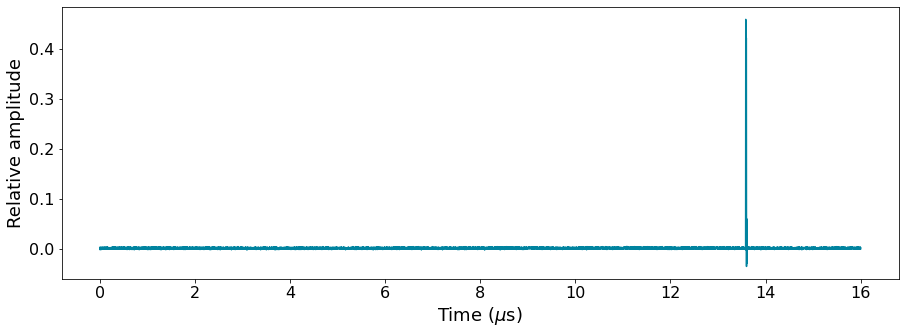

## TTL Acquisition

We can now set a correct threshold for the Trigger Count acquisition to ensure all the photon arrivals are counted a single time.

In [ ]:
hardware_cfg = set_hardware_config(ttl_acq_threshold=0.3)
nv_center.hardware_config.set(hardware_cfg)

qe0.measure.pulse_duration(20e-6)
qe0.measure.acq_duration(20e-6)

def ttl_acquisition_sched(qubit,repetitions=1):
    schedule = Schedule("TTL Acquisition")
    schedule.add(Measure("qe0", acq_protocol="TriggerCount"))
    schedule.repetitions=repetitions
    return schedule

schedule = ttl_acquisition_sched("qe0")
compiled_sched = compiler.compile(schedule, nv_center.generate_compilation_config())

compiled_sched.plot_pulse_diagram(plot_backend="plotly")

In [ ]:
sched_kwargs = {
    "qubit": "qe0",
}

ttl_acquisition_gettable = ScheduleGettable(
    quantum_device=nv_center,
    schedule_function=ttl_acquisition_sched,
    schedule_kwargs=sched_kwargs,
    batched=True,
    data_labels=["Trigger Count"]
)
ttl_acquisition_gettable.unit = [""]

In [ ]:
result = ttl_acquisition_gettable.get()
print('Photons counted: ' + str(result[0][0]))

In [ ]:
rep_par = ManualParameter(
    name="repetitions",
    unit="",
    label="Repetitions",
)
rep_par.batched = True
repetitions = 200
meas_ctrl.settables(rep_par)
meas_ctrl.setpoints(np.asarray(range(repetitions)))
meas_ctrl.gettables(ttl_acquisition_gettable)
dataset = meas_ctrl.run()

In [ ]:
photon_count = dataset.y0

plt.hist(photon_count, bins=range(1,10),align='left',rwidth=0.9,color="#00839F")
plt.title("Photon counts for 200 acquisitions of 20 $\mu$s")
plt.xlabel("Trigger Count")
plt.ylabel("# of Occurences")
plt.show()

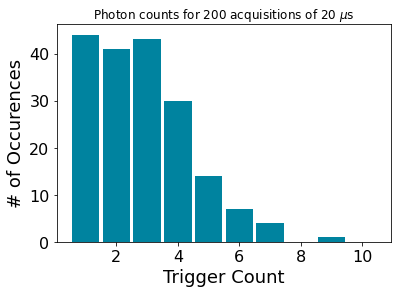

## Quantify - NV Center Native Library 

We define a schedule consisting of a Charge Reset operation which sets the NV to its negative charge state NV$^-$, followed by a Charge and Resonance Count operation which runs the ionization and the spin pump lasers with a photon count, on the element `qe0`. These operations are defined in `quantify_scheduler.operations.nv_native_library`.

In [ ]:
from quantify_scheduler.enums import BinMode
from quantify_scheduler.operations.nv_native_library import ChargeReset, CRCount
from quantify_scheduler.operations.shared_native_library import SpectroscopyOperation

qe0.clock_freqs.ionization.set(564e12)  # 532 nm
qe0.clock_freqs.ge1.set(470.4e12 - 5e9)  # slightly detuned
qe0.clock_freqs.f01.set(3.592e9)
qe0.clock_freqs.spec.set(2.895e9)

In [ ]:
# Define ChargeReset parameters
green_voltage = 0.697  # 30 uW

qe0.charge_reset.amplitude(green_voltage)
qe0.charge_reset.duration(40e-6)

In [ ]:
# Define CRCount parameters
readout_voltage = 0.5  
spinpump_voltage = 0.15

qe0.cr_count.readout_pulse_amplitude(readout_voltage)
qe0.cr_count.spinpump_pulse_amplitude(spinpump_voltage)
qe0.cr_count.acq_delay(5e-6)
qe0.cr_count.acq_duration(40e-6)
qe0.cr_count.readout_pulse_duration(45e-6)
qe0.cr_count.spinpump_pulse_duration(45e-6)

For this schedule, three lasers are used, as well as the other modules in the cluster. Since these are not present in the hardware configuration defined above, a new hardware configuration listing all the hardware is necessary. We load an example json hardware configuration file present in `quantify_scheduler`, which contains all the instruments required. Additionally, these are added to the instrument coordinator.

In [ ]:
lo_spinpump_laser = MockLocalOscillator("lo_spinpump_laser")
lo_green_laser = MockLocalOscillator("lo_green_laser")

ic.add_component(
    GenericInstrumentCoordinatorComponent(lo_spinpump_laser)
)
ic.add_component(
    GenericInstrumentCoordinatorComponent(lo_green_laser)
)

In [ ]:
# Define Schedule
def nv_schedule(qubit,repetitions=1):
    sched = Schedule("NV Center Schedule")
    sched.add(ChargeReset(qubit))
    sched.add(CRCount(qubit, acq_index=0, acq_protocol="TriggerCount", bin_mode=BinMode.APPEND))
    return sched

compiled_nv_sched = compiler.compile(nv_schedule("qe0"), nv_center.generate_compilation_config())
compiled_nv_sched.plot_pulse_diagram(plot_backend="plotly")
compiled_nv_sched.plot_circuit_diagram()

In [ ]:
sched_kwargs = {
    "qubit": "qe0",
}

nv_gettable = ScheduleGettable(
    quantum_device=nv_center,
    schedule_function=nv_schedule,
    schedule_kwargs=sched_kwargs,
    batched=True,
    data_labels=["Trigger Count"]
)
nv_gettable.unit = [""]

In [ ]:
result = nv_gettable.get()
print('Photons counted: ' + str(result[0][0]))

## Dark ESR Schedule

We turn now to the dark electron spin resonance (ESR) experiment. 
A predefined schedule has been defined in the Quantify Scheduler library, which uses the numerically controled oscillator frequency sweeping capabilities (see NCO Control tutorial for more information) to perform the spectroscopy operation in a defined frequency range. To ensure the NV center is in the correct state, after the Reset operation, a Charge Resonance check is performed before and after each Measure operation.

In [ ]:
# Reset Operation
spinpump_reset_voltage = 0.502  # 0.5 uW
qe0.reset.amplitude(spinpump_reset_voltage)
qe0.reset.duration(3e-6)

In [ ]:
# Spectroscopy Operation
qe0.spectroscopy_operation.amplitude(0.25)
qe0.spectroscopy_operation.duration(3e-6)

In [ ]:
from quantify_scheduler.schedules.spectroscopy_schedules import nv_dark_esr_sched_nco

spec_frequencies = np.asarray(np.linspace(2.898e9, 3.098e9, 20))

compiler = SerialCompiler("compiler")
compiled_nv_sched = compiler.compile(
    schedule=nv_dark_esr_sched_nco("qe0", spec_clock="qe0.spec", spec_frequencies=spec_frequencies), config=nv_center.generate_compilation_config()
)

In [ ]:
schedule_kwargs = {
    "qubit": "qe0",
    "spec_clock": "qe0.spec",
    "spec_frequencies": spec_frequencies,
    }

dark_esr_gettable = ScheduleGettable(
                quantum_device=nv_center,
                schedule_function=nv_dark_esr_sched_nco,
                schedule_kwargs=schedule_kwargs,
                batched=True,
                data_labels=["Trigger Count"]
            ) 
dark_esr_gettable.unit = [""]

In [ ]:
acq_par = ManualParameter(
    name="acq_index",
    unit="",
    label="Acquisition Index",
)
acq_par.batched = True

In [ ]:
meas_ctrl.settables([acq_par, qe0.clock_freqs.spec])
meas_ctrl.setpoints_grid([np.asarray([0, 1, 2]), spec_frequencies])
meas_ctrl.gettables(dark_esr_gettable)
dataset = meas_ctrl.run()

In [ ]:
rep_par = ManualParameter(
    name="repetitions",
    unit="",
    label="Repetitions",
)
rep_par.batched = True

In [ ]:
repetitions = 10

meas_ctrl.settables([acq_par, rep_par, qe0.clock_freqs.spec])
meas_ctrl.setpoints_grid([np.asarray([0, 1, 2]), np.asarray(range(repetitions)), spec_frequencies])
meas_ctrl.gettables(dark_esr_gettable)
dataset = meas_ctrl.run()